<a href="https://colab.research.google.com/github/IndraP24/Skin-Cancer-Detector/blob/main/notebooks/Skin_Cancer_Classification_Custom_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May  2 17:41:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
#import the important libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

The data is obtained from Kaggle. The data loading from Kaggle is shown below.

There are 7 Classes in that data as follows: 
 
0: Actinic keratoses and intraepithelial carcinoma / Bowen's disease >> `akiec`
 
1: Dermatofibroma >> `df`

2: Benign keratosis-like lesions >> `bkl`

3: Melanoma >> `mel`

4: Melanocytic nevi >> `nv`

5: Vascular lesions >> `vasc`

6: Basal cell carcinoma >> `bcc`


# Loading data using Kaggle API

In [3]:
# Create a directory called ".kaggle"
!mkdir ~/.kaggle

In [4]:
# Place the kaggle.json file in the directory
!cp kaggle.json ~/.kaggle/

In [5]:
# Set permissions of 600 ---> which means that the owner has full read and write access to the file, while no other user can access the file
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Search for the ham10000 dataset in kaggle datasets
! kaggle datasets list -s ham10000

ref                                               title                                            size  lastUpdated          downloadCount  
------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
kmader/skin-cancer-mnist-ham10000                 Skin Cancer MNIST: HAM10000                       5GB  2018-09-20 20:36:13          39610  
tschandl/ham10000-lesion-segmentations            HAM10000 Lesion Segmentations                    10MB  2020-07-02 21:20:22            190  
andrewmvd/isic-2019                               Skin Lesion Images for Melanoma Classification    9GB  2020-05-28 05:11:34           2105  
artakusuma/basedir                                HAM10000 Preprocessed Data                        6GB  2019-03-17 05:03:33             60  
tsaideepak/skin-cancer                            skin cancer                                     462MB  2019-03-23 19:39:19            452  
discdi

In [7]:
# Download the ham10000 dataset
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:49<00:00, 34.5MB/s]
100% 5.20G/5.20G [01:49<00:00, 51.1MB/s]


In [9]:
# Unzip images and place them in a directory
!mkdir skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d skin-cancer-mnist-ham10000

Streaming output truncated to the last 5000 lines.
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: skin-cancer-mnist-ham10000/ham1000

In [13]:
df = pd.read_csv('../content/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
df = df.sample(frac = 1)
data = df.iloc[:,:-1]
labels = df.iloc[:,-1:]
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1629,193,165,170,194,168,174,198,177,183,198,176,183,198,176,180,200,179,186,200,178,184,198,173,176,200,176,183,200,174,179,198,169,174,196,171,178,196,168,176,195,...,191,160,169,194,168,182,192,164,176,188,157,168,187,156,162,187,159,167,188,166,178,188,169,181,188,171,181,183,165,170,179,162,166,180,166,174,175,156,159,6
2974,126,106,101,167,141,134,174,148,146,181,157,159,190,164,169,194,171,176,197,172,177,201,174,180,206,180,189,208,181,185,209,180,183,211,182,183,210,182,182,212,...,175,132,139,167,119,123,157,105,112,152,99,110,148,98,101,143,86,91,143,94,94,136,92,87,126,81,78,117,68,68,104,66,67,68,48,49,31,18,21,1
1253,201,171,185,202,174,187,202,174,188,202,172,184,202,171,186,204,175,190,203,172,185,205,176,190,205,177,191,204,176,190,205,175,189,205,176,190,203,172,187,203,...,203,176,187,203,175,185,201,171,180,201,168,178,201,167,180,201,168,180,203,172,185,201,170,180,199,167,178,199,167,180,199,168,183,200,171,186,199,169,182,6
3318,217,136,139,217,128,129,217,128,127,220,132,133,219,130,133,220,128,127,222,133,132,223,138,135,223,141,129,221,138,130,224,139,133,225,141,134,223,144,137,223,...,206,129,130,209,133,132,210,138,138,211,142,142,213,144,143,208,136,132,204,130,124,206,129,123,203,125,122,200,118,119,201,122,121,198,126,121,201,133,129,4
5887,194,90,104,196,94,108,195,94,109,198,96,112,198,93,114,198,93,116,197,95,115,202,99,117,200,95,110,204,100,116,207,106,119,203,98,107,204,97,107,202,...,193,98,99,191,93,92,189,93,93,186,86,88,191,94,95,188,94,91,184,90,88,179,82,79,181,84,81,179,88,91,176,85,87,179,90,91,173,83,87,4


In [15]:
labels.head(30)

,label
1629,6
2974,1
1253,6
3318,4
5887,4
7049,4
1455,6
573,2
6433,4
776,2


As you can see here in the distribution of data 

There is no balance in the data "very much impalance data"

Which leads to a significant effect on the values of accuracy, F1 score and ... Atc 

[Text(0, 0, 'akiec'),
 Text(0, 0, 'df'),
 Text(0, 0, 'bkl'),
 Text(0, 0, 'mel'),
 Text(0, 0, 'nv'),
 Text(0, 0, 'vasc'),
 Text(0, 0, 'bcc')]

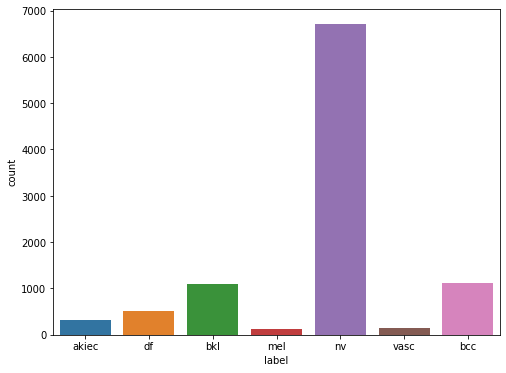

In [51]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
ax = sns.countplot(x='label', data=df)
ax.set_xticklabels(type_of_cancer)

So what's the solution?

We're going to solve this problem in two steps. 

1. We can duplicate the other classes "randomly " other than 'nv' class


2. generate new images with 'ImageDataGenarator' from Keras 

These two solutions worked very well. 


In [17]:
df = df.sort_values('label')
df = df.reset_index()

In [18]:
df

,index,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,9713,61,19,22,136,69,68,209,142,141,243,181,175,251,194,191,252,197,193,252,194,188,251,191,183,251,191,181,250,186,175,251,189,178,250,190,180,246,185,174,...,239,168,163,226,141,139,234,159,152,240,174,166,238,167,158,237,168,159,238,170,162,228,151,140,225,147,137,226,149,148,214,137,141,174,99,104,107,42,44,0
1,9793,129,91,92,182,145,145,205,169,168,189,154,154,194,162,162,210,176,173,209,176,175,212,183,183,215,189,194,217,190,199,218,191,201,218,190,197,218,190,201,...,210,177,179,215,184,187,211,176,174,212,175,176,215,186,190,215,187,193,203,170,162,196,158,150,181,144,141,139,104,99,64,39,41,5,2,6,2,2,1,0
2,9749,179,123,105,191,138,123,199,146,133,191,132,112,198,140,121,220,172,163,226,178,170,229,182,174,225,178,175,231,184,182,234,186,182,231,183,178,231,182,179,...,236,191,189,230,180,172,227,179,171,221,172,168,210,158,154,207,155,147,208,159,155,191,142,143,191,144,147,185,138,141,173,123,120,154,101,86,143,93,83,0
3,9715,130,78,77,138,81,77,156,106,102,177,138,138,197,170,167,203,175,173,207,182,180,204,175,174,206,179,177,205,175,176,200,166,168,204,173,178,208,179,182,...,154,108,116,149,96,105,154,105,113,146,92,102,150,101,109,149,100,106,152,107,112,154,110,114,153,111,111,148,106,105,141,95,96,134,86,88,139,99,97,0
4,9702,106,55,81,97,47,75,89,36,72,101,45,80,135,90,123,148,101,129,147,90,109,156,99,122,164,109,133,175,125,145,190,145,164,189,144,161,192,150,163,...,207,186,195,207,187,193,208,191,198,203,182,189,204,181,186,200,179,185,198,181,190,193,169,177,189,166,173,171,149,156,176,153,160,180,159,169,174,154,162,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,1336,44,23,33,91,64,69,138,103,99,162,128,132,172,141,149,180,149,159,177,142,157,168,131,149,176,150,165,176,148,163,165,132,152,153,116,138,139,93,111,...,23,9,9,22,7,7,17,4,5,12,1,4,10,1,4,10,1,5,18,11,20,25,19,25,10,2,6,17,4,10,53,27,34,65,36,45,65,35,46,6
10011,2111,159,102,99,173,119,115,184,131,130,190,140,142,194,143,143,198,150,148,206,161,166,211,168,177,213,169,175,219,178,184,214,170,174,199,145,144,210,161,160,...,207,163,164,209,166,169,211,170,176,194,144,143,202,157,159,199,156,158,187,134,132,182,126,123,176,117,115,180,124,125,179,127,132,165,112,122,145,91,94,6
10012,2015,231,202,214,235,208,222,235,208,222,235,209,221,236,206,219,237,208,222,238,215,225,240,217,229,237,206,221,229,182,199,228,179,188,214,147,148,187,103,104,...,182,123,113,170,109,98,193,142,126,207,164,153,205,156,147,197,144,134,206,157,154,217,179,176,224,192,192,226,205,205,230,214,212,235,228,221,236,235,227,6
10013,1949,253,186,187,254,191,196,254,195,216,254,193,211,254,190,218,254,187,211,254,183,189,254,187,198,254,188,204,254,183,191,248,168,163,245,157,153,252,169,176,...,248,163,171,247,155,154,248,156,161,251,165,175,251,169,184,254,173,194,253,175,192,250,170,183,249,164,182,251,169,192,252,174,199,251,171,188,250,170,184,6


Here we duplicate the class of the data for some amount of times

In [19]:

index0 = df[df['label'] == 0].index.values
index1 = df[df['label'] == 1].index.values
index2 = df[df['label'] == 2].index.values
index3 = df[df['label'] == 3].index.values
index5 = df[df['label'] == 5].index.values
index6 = df[df['label'] == 6].index.values


In [20]:

df0 = df.iloc[int(min(index0)):int(max(index0)+1)]
df1 = df.iloc[int(min(index1)):int(max(index1)+1)]
df2 = df.iloc[int(min(index2)):int(max(index2)+1)]
df3 = df.iloc[int(min(index3)):int(max(index3)+1)]
df5 = df.iloc[int(min(index5)):int(max(index5)+1)]
df6 = df.iloc[int(min(index6)):int(max(index6)+1)]


we have taken some optimal value such that the distribution of the total data is somewhat centralized

In [21]:

df_index0 = df0.append([df0]*17, ignore_index = True)
df_index1 = df1.append([df1]*15, ignore_index = True)
df_index2 = df2.append([df2]*5, ignore_index = True)
df_index3 = df3.append([df3]*52, ignore_index = True)
df_index5 = df5.append([df5]*45, ignore_index = True)
df_index6 = df6.append([df6]*5, ignore_index = True)

frames = [df, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

In [22]:

final_df = pd.concat(frames)
final_df.drop('index', inplace = True, axis = 1)
final_df = final_df.sample(frac = 1)
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1:]

We can now see that The Distribution of The  classes are more Normalized and More Balance

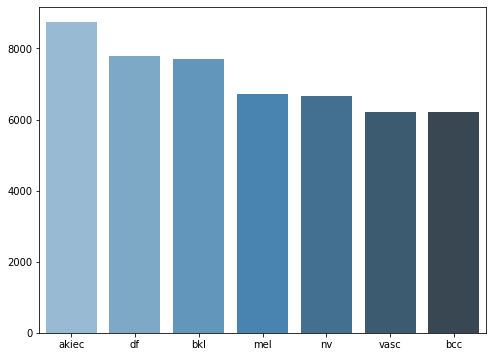

In [23]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_of_cancer, y = counts ,palette="Blues_d")


Now we can divide the data. 

X : feature "for the data "

Y : labels "for the lables"





In [24]:
X = np.array(data)
Y = np.array(labels)

reshaping the data

In [25]:

X = X.reshape(-1,28,28,3)

print( X.shape)
print( Y.shape)

(50024, 28, 28, 3)
(50024, 1)


normalize the data 

![image.png](attachment:image.png)

In [26]:
X = (X-np.mean(X))/np.std(X)


splitting the data into train and the testing data

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)



(40019, 28, 28, 3)
(10005, 28, 28, 3)
(40019, 1)
(10005, 1)


augmented data with  ImageDataGenerator

In [29]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

now it's time to make the model and train it

In [30]:
model = Sequential([
    
    Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2)),

    Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Flatten(),
    
    Dense(64, activation = 'relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')]
)


Adjust learning rate and the optimizer 

In [35]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

In [36]:

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          3

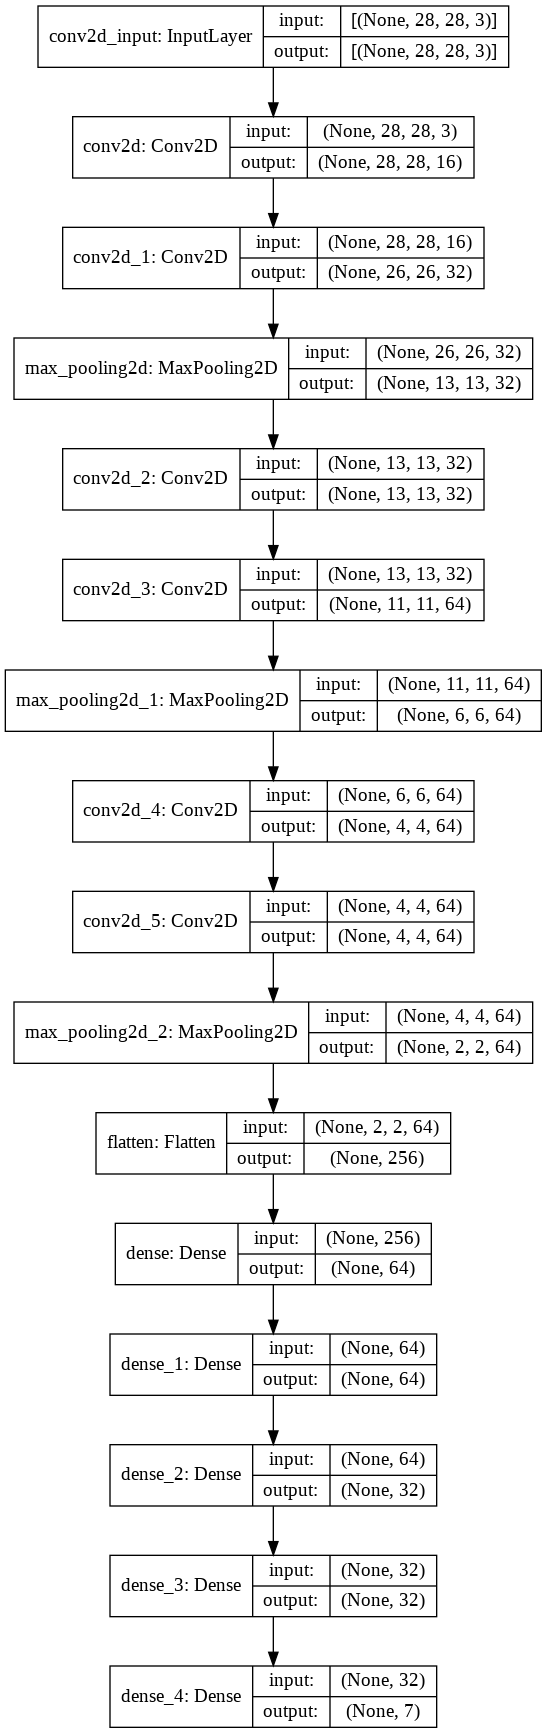

In [38]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
epochs = 20

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = epochs,
                    callbacks=[learning_rate_reduction]) 

Epoch 1/20
501/501 [==============================] - 35s 8ms/step - loss: 1.5482 - accuracy: 0.3706 - val_loss: 1.1649 - val_accuracy: 0.5475
Epoch 2/20
501/501 [==============================] - 3s 5ms/step - loss: 0.9439 - accuracy: 0.6379 - val_loss: 0.7182 - val_accuracy: 0.7219
Epoch 3/20
501/501 [==============================] - 3s 5ms/step - loss: 0.6112 - accuracy: 0.7711 - val_loss: 0.4520 - val_accuracy: 0.8307
Epoch 4/20
501/501 [==============================] - 3s 5ms/step - loss: 0.4172 - accuracy: 0.8429 - val_loss: 0.3282 - val_accuracy: 0.8684
Epoch 5/20
501/501 [==============================] - 3s 5ms/step - loss: 0.3161 - accuracy: 0.8783 - val_loss: 0.2723 - val_accuracy: 0.8953
Epoch 6/20
501/501 [==============================] - 3s 5ms/step - loss: 0.2565 - accuracy: 0.9037 - val_loss: 0.2045 - val_accuracy: 0.9245
Epoch 7/20
501/501 [==============================] - 3s 5ms/step - loss: 0.1899 - accuracy: 0.9314 - val_loss: 0.1564 - val_accuracy: 0.9412
Epoch

the model acc

In [40]:
model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("the test model accuracy =",model_acc_test * 100)

the test model accuracy = 96.40179872512817


different performance measure for the model 

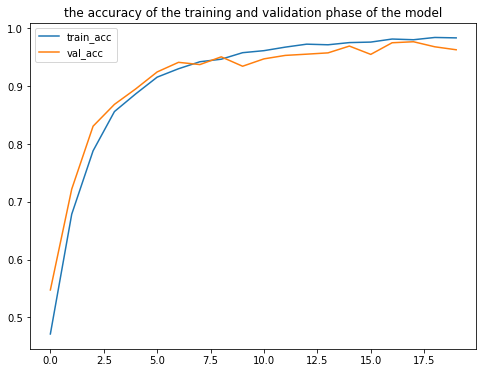

In [41]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("the accuracy of the training and validation phase of the model")
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.legend()

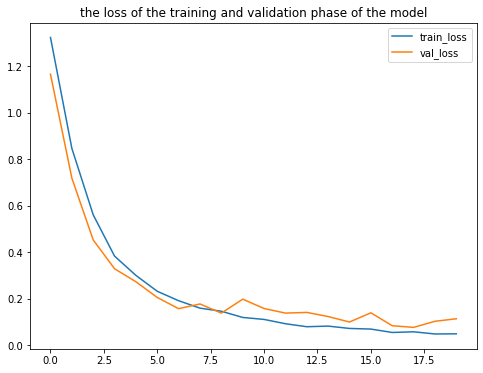

In [42]:
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("the loss of the training and validation phase of the model")
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()

confusion matrix

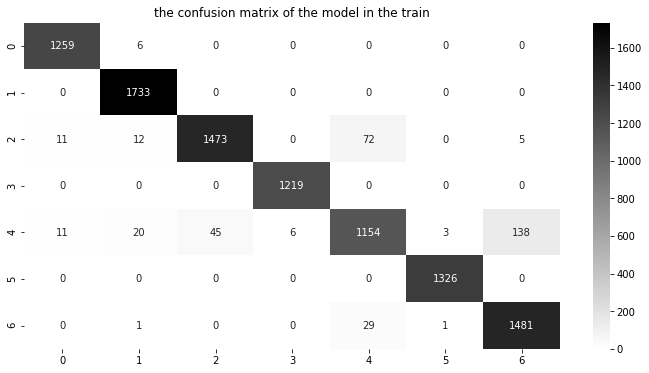

In [43]:

Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

classification_report_model  contain 

- precision

- recall

- f1-score

- accuracy

for our model 

In [44]:

label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

          nv       0.98      1.00      0.99      1265
         mel       0.98      1.00      0.99      1733
         bkl       0.97      0.94      0.95      1573
         bcc       1.00      1.00      1.00      1219
       akiec       0.92      0.84      0.88      1377
        vasc       1.00      1.00      1.00      1326
          df       0.91      0.98      0.94      1512

    accuracy                           0.96     10005
   macro avg       0.96      0.96      0.96     10005
weighted avg       0.96      0.96      0.96     10005



In [45]:
model.save('my_model.h5')